# Instructions of this exercise

This jupyter notebook is an exercise for you to practice with basic speech classification with neural networks.

The different sections have comments that will guide you through the different stages of the processing.

You will find parts in this notebook that are missing. They are marked with a "TODO", with an explanation about what you are supposed to write or code in that gap. Sometimes you may be requested to implement an algorithm or a piece of code that behaves in a specific way. Other times, you may be requested to explain what a specific piece of code does or why it is needed. In some cases, the requests may contain a "trap", e.g. the thing you are requested to implement can't be done for whatever reason, or it may need an extra preprocessing step for it to be possible.

If you have any doubt, do not hesitate to contact the instructor at noe.casas@upc.edu

# Requirements

In order to follow this notebook you need working knowledge on:

- Python programming.
- Pytorch basics. Do not forget to check the pytorch documentation to understand the purpose of each function/class, as well as what inputs they expect and what kind of result the give.
- Signal processing basics (e.g. Mel spectrograms).
- Convolutional networks. A good general starting point may be [Stanford's CS231n course](http://cs231n.github.io/convolutional-networks/).
- Unix command line basics.

If you lack any of them, please acquire the needed knowledge on the internet, where there is plenty of material about the three topics.

# Installation of extra libraries

First, let's install some libraries that may be missing from your python environment:

- librosa: a must for audio processing. Here we will be using mainly to compute the Mel spectrogram.
- soundfile: to load waveform files. We could also have used librosa, but librosa's file loading function resamples the waveform by default and it is somewhat error prone (see [this post](https://librosa.github.io/blog/2019/07/17/resample-on-load/#resample-on-load) for further info).
- pillow: API-compatible successor of PIL (Python Imaging Library), which is a widely used python library.
- pytorch

In [0]:
!pip install pysoundfile librosa torch pillow

In [0]:
# avoid jupyter printing the last result by default

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"


## Reproducibility

We fix the random seed for reproducibility purposes. See this for details:
https://pytorch.org/docs/stable/notes/randomness.html

In [0]:
import torch
import numpy as np

seed = 321
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

# Free Spoken Digit dataset

For this notebook we will be using a dataset called Free Spoken Digit dataset. It is a collection of utterances of digits, from 0 to 9, by 4 different speakers. It is meant to be the MNIST for speech.

We will download it first:

In [0]:
!wget -q -O repo.zip https://github.com/Jakobovski/free-spoken-digit-dataset/archive/master.zip
!unzip -q -o repo.zip
!rm -rf repo.zip recordings
!mv free-spoken-digit-dataset-master/recordings .
!rm -rf free-spoken-digit-dataset-master train valid test

Given that we have labels for both the speaker and the digit, we could classify the utterances for any of those aspects. **In this exercise, we will be clasifying utterance digit**.

# Mel Spectrogram computation and storage as images

We will not be dealing with the waveforms directly, but we will be computing the Mel spectrogram.

Let's define a couple of functions that we will be using to conver waveforms to spectrograms:

In [0]:
from librosa import power_to_db
from librosa.feature import melspectrogram
from PIL import Image


def sound2mel(audio_signal, sample_rate):
    """Computes the Mel spectrogram (in dB) of the given audio signal."""

    n_fft = 1024
    hop_length = 256
    n_mels = 40
    fmin = 20
    fmax = sample_rate / 2 
    
    # compute the Mel spectrogram with librosa
    mel_spec_power = melspectrogram(audio_signal,
                                    sr=sample_rate,
                                    n_fft=n_fft, 
                                    hop_length=hop_length, 
                                    n_mels=n_mels,
                                    power=2.0, 
                                    fmin=fmin,
                                    fmax=fmax)
    
    # See this to better understand what you get into mel_spec_power:
    #     https://stackoverflow.com/q/52232839/674487

    # Let's better handle the spectrogram in dB
    mel_spec_db = power_to_db(mel_spec_power, ref=np.max)

    return mel_spec_db

def to_grayscale_image(spec):
    """Takes a spectrogram and fits it into a 8-bit image"""
    img = (((spec - spec.min()) / (spec.max() - spec.min())) * 255.9).astype(np.uint8)
    return Image.fromarray(img)

In order to make it easier to handle the utterance as spectrograms and feed them to our neural networks, we will store these spectrograms as normal images, so that later we can use image classification data loaders.

As we convert the waveforms to spectrogram and save them as images, we will also split them into training, validation and test sets. For this, we will take one of the four speakers ("yweweler") and we will use some of his utterances for validation and some for test. Each data split will be under a different directory (i.e. train/valid/test).

Note that under each data split directory, we will have subdirectories for each different digit. We will use this later to get the utterance label.

In [0]:
import os
import soundfile


SPEAKERS = ['jackson', 'nicolas', 'theo', 'yweweler']
N_SPEAKERS = 4
N_DIGITS = 10
N_REPETITIONS = 50

for speaker_index, speaker in enumerate(SPEAKERS):
    for digit in range(N_DIGITS):
        for repetition in range(N_REPETITIONS):
            sound_file = 'recordings/{}_{}_{}.wav'.format(digit, speaker, repetition)
            audio_signal, sampling_rate = soundfile.read(sound_file)
            spectrogram = sound2mel(audio_signal, sampling_rate)
            split = ('test' if speaker == 'yweweler' and repetition < 25
                     else 'valid' if speaker == 'yweweler'
                     else 'train') 
            dirname = '{}/{}'.format(split, digit)
            os.makedirs(dirname, exist_ok=True)
            img_file = '{}/{}_{}_{}.png'.format(dirname, digit, speaker, repetition)
            to_grayscale_image(spectrogram).save(img_file)

# Data loading

Now that we have our utterances stored as spectrogram images, we will prepare the data loading. For this, we will use **torchvision** data loaders, together with standard transformations. The most important transformation is the resizing. Take into account that the length of the utterances is not constant, but each utterance can have a different duration, which leads to Mel spectrograms of different lengths (the number of channels is fixed, though). In order to overcome this, we will simply rescale the image to a constant size.

In [0]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
                transforms.Grayscale(),
                transforms.Resize((128, 64)),
                transforms.ToTensor(),
])

train_data = ImageFolder(root='./train', transform=transform)
train_loader = DataLoader(train_data, batch_size=20, shuffle=True, num_workers=4)

valid_data = ImageFolder(root='./valid', transform=transform)
valid_loader = DataLoader(valid_data, batch_size=20, shuffle=True, num_workers=1)

test_data = ImageFolder(root='./test', transform=transform)
test_loader = DataLoader(test_data, batch_size=20, shuffle=True, num_workers=1)

Note that, by default, `ImageFolder` takes the labels from the directories directly under the root folder. This means that the image files under `train/2` will be labeled as '2', those under `train/7` will be labeled as '7'.

This is how one of our spectrograms look like:

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


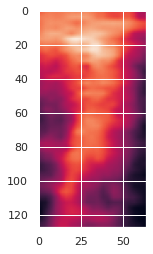

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.imshow(train_data[0][0].squeeze().cpu().numpy())

# Training and Evaluation Routines

Let's define some functions to train our model and evaluate it under the validation set:

In [0]:
def train_epoch(model, criterion, optimizer, train_loader, log_interval, epoch):
    # sets the model in "training mode", so dropout, BN, etc are active
    model.train()

    num_batches = len(train_loader)

    losses = []
    for batch_idx, batch in enumerate(train_loader):

        input, targets = batch

        model.zero_grad()

        output = model(input.cuda())
        loss = criterion(output, targets.cuda())
        loss.backward()

        optimizer.step()

        losses.append(loss.item())

        if log_interval and batch_idx % log_interval == 0:
            percentage = 100 * batch_idx // num_batches
            msg = 'epoch {}, progress: {}% avg.loss: {}'
            print(msg.format(epoch, percentage, losses[-1]))
    
    return losses

In [0]:
def evaluate(model, criterion, loader):

    # Sets the model in "evaluation mode" so dropout, BN, etc are deactivated.
    model.eval()

    num_total_elems = 0
    loss = 0.
    targets = []
    preds = []
    with torch.no_grad():
        for batch in loader:
            input, target = batch
            batch_size = input.size(0)
            logits = model(input.cuda())
            batch_loss = criterion(logits, target.cuda()).item()
            loss += batch_size * batch_loss
            num_total_elems += batch_size
            targets.extend(target.numpy().tolist())
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy().tolist())
    
    loss = loss / num_total_elems

    return loss, targets, preds

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


def train_model(model, lr, num_epochs, train_loader, valid_loader, log_interval):

    # The output of the model must be compatible with this loss function
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(lr=lr, params=model.parameters())

    train_losses = []
    valid_losses = []
    for epoch in range(num_epochs):
        epoch_losses = train_epoch(model,
                                   criterion,
                                   optimizer,
                                   train_loader,
                                   log_interval,
                                   epoch)
        train_losses.extend(epoch_losses)

        valid_loss, _, _ = evaluate(model, criterion, valid_loader)
        valid_losses.append(valid_loss)

        print('epoch {}, validation loss: {:.3f}'.format(epoch, valid_loss))

    return train_losses, valid_losses

# Our Neural Network

Now it's time to define a neural network that can address the classification problem at hand:

In [0]:
class DigitClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: declare whatever modules you need
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(4,4), padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(4,4), padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=(3,3), stride=3)
        self.lin1 = nn.Linear(64*13*6, 128)
        self.lin2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()

    def forward(self, input):
        x = input
        # TODO: implement whatever model you want, ensuring it achieves
        #       decent accuracy. You could probably try with
        #       convolutional layers, residual connections, etc.
        #       Given the small size of the training data, you may
        #       also want to use some sort of regularization.
        #       Note that the result of the forward computation of the
        #       model must be compatible with the loss function used for
        #       the training (see functions train_epoch and train_model).
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 64*13*6)
        x = self.lin1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.lin2(x)

        return x

# Training

Now it's time to train our model.

In [0]:
# TODO: select an appropriate set of hyperparameters, either in
#       this cell (learning rate, number of epochs, etc), or
#       throughout the notebook (e.g. batch size). Also, consider
#       techniques such as early stopping to avoid overfitting.

NUM_EPOCHS = 50
LOG_INTERVAL = 40

model = DigitClassificationModel().cuda()
train_losses, valid_losses = train_model(model,
                                         0.0001,
                                         NUM_EPOCHS,
                                         train_loader,
                                         valid_loader,
                                         LOG_INTERVAL)

epoch 0, progress: 0% avg.loss: 2.30976939201355
epoch 0, progress: 53% avg.loss: 2.1729485988616943
epoch 0, validation loss: 2.077
epoch 1, progress: 0% avg.loss: 2.0506606101989746
epoch 1, progress: 53% avg.loss: 1.7587025165557861
epoch 1, validation loss: 1.448
epoch 2, progress: 0% avg.loss: 1.577439308166504
epoch 2, progress: 53% avg.loss: 1.4383951425552368
epoch 2, validation loss: 1.248
epoch 3, progress: 0% avg.loss: 0.863735020160675
epoch 3, progress: 53% avg.loss: 0.7695221900939941
epoch 3, validation loss: 1.020
epoch 4, progress: 0% avg.loss: 0.7752445340156555
epoch 4, progress: 53% avg.loss: 0.500619113445282
epoch 4, validation loss: 0.950
epoch 5, progress: 0% avg.loss: 0.7021391987800598
epoch 5, progress: 53% avg.loss: 0.4494304656982422
epoch 5, validation loss: 0.874
epoch 6, progress: 0% avg.loss: 0.3576187789440155
epoch 6, progress: 53% avg.loss: 0.3351166546344757
epoch 6, validation loss: 0.780
epoch 7, progress: 0% avg.loss: 0.32616809010505676
epoch 7,

Let's visualize the training/validation losses to understand if our model is overfitting:

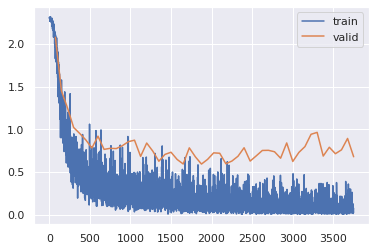

In [0]:
plt.plot(train_losses, label='train')
valid_x_axis = [(1 + k) * len(train_losses)/len(valid_losses)
                for k in range(len(valid_losses))]
plt.plot(valid_x_axis, valid_losses, label='valid')
plt.legend()

# Performance Evaluation

Now we will evaluate our model in the test set. For this, we will compute the predictions of the model over the test set and compare them against the true labels in a **confusion matrix**:

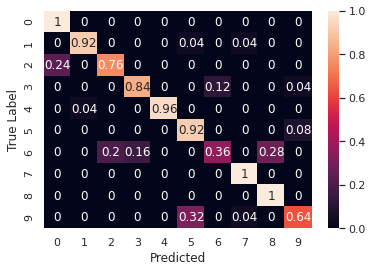

In [0]:
from sklearn.metrics import confusion_matrix


_, target, preds = evaluate(model, nn.CrossEntropyLoss(), test_loader)

cm = confusion_matrix(target, preds)
relative_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(relative_cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True Label")